# Tucker: Number of components. 
Methods used: DIFFIT, BIC, SVD

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorly as tl
from tensorly.cp_tensor import CPTensor
from tensorly.tucker_tensor import TuckerTensor, tucker_to_tensor
from tensorly.tenalg import multi_mode_dot
import math
from tensorly.decomposition import tucker, non_negative_tucker, non_negative_tucker_hals
from scipy.interpolate import interp1d
import tlviz
import scipy.io
from sklearn.model_selection import KFold
from scipy.linalg import svd

# Import tensors

In [2]:
tensor_70_cent = np.load('tensors_center/tensor_70.npy')
tensor_100_cent = np.load('tensors_center/tensor_100.npy')
tensor_200_cent = np.load('tensors_center/tensor_200.npy')
tensor_300_cent = np.load('tensors_center/tensor_300.npy')

tensors_cent = [tensor_70_cent, tensor_100_cent, tensor_200_cent, tensor_300_cent]
tensor_names_cent = ['70', '100', '200', '300']

# DIFFIT

In [25]:
best_ranks = []
best_fits = []
valid_ranks = []
tensor = tensor_70_cent # change tensor
model = tucker # change model

for i in range(1, tensor.shape[0]+1):
    for j in range(1, tensor.shape[1]+1):
        for k in range(1, tensor.shape[2]+1):
            if i <= j*k and j <= i*k and k <= i*j:
                valid_ranks.append([i, j, k])

valid_ranks = np.array(valid_ranks)

unique_s = np.unique(np.sum(valid_ranks, axis=1))

for s in unique_s:
    ranks_s = valid_ranks[np.sum(valid_ranks, axis=1) == s]

    best_fit = 0
    best_rank = []

    for rank in ranks_s:
        core_tensor, factors = model(tensor, list(rank))

        reconstructed_tensor = tl.tucker_to_tensor((core_tensor, factors))

        fit = 100 * (np.sum(tensor**2) - np.sum((tensor - reconstructed_tensor)**2)) / np.sum(tensor**2)

        if fit > best_fit:
            best_fit = fit
            best_rank = rank

    best_ranks.append(best_rank)
    best_fits.append(best_fit)

In [10]:
df = pd.DataFrame(best_ranks, columns=['P', 'Q', 'R'])
df['Fit'] = best_fits
df.to_csv('best_ranks_and_fits.csv', index=False)

# BIC

In [3]:
def compute_BIC(tensor, core, factors, gamma):
    reconstructed_tensor = tl.tucker_to_tensor((core, factors))
    
    RSS = np.sum((tensor - reconstructed_tensor) ** 2)

    n = np.prod(tensor.shape)
    
    core_params = np.prod(core.shape)
    factor_params = sum([np.prod(f.shape) for f in factors])
    k = core_params + factor_params

    BIC = n * np.log(RSS / n) + gamma * k * np.log(n)

    return BIC

In [4]:
def bic_best_ranks(gamma_values, tensor, model,t):
    valid_ranks = []
    
    for i in range(1, tensor.shape[0] + 1):
        for j in range(1, tensor.shape[1] + 1):
            for k in range(1, tensor.shape[2] + 1):
                if i <= j * k and j <= i * k and k <= i * j and i + j + k <= t:
                    valid_ranks.append([i, j, k])

    valid_ranks = np.array(valid_ranks)
    unique_s = np.unique(np.sum(valid_ranks, axis=1))

    gamma_ranks = []
    gamma_bics = []

    for gamma in gamma_values:
        best_ranks = []
        best_bics = []
        
        for s in unique_s:
            ranks_s = valid_ranks[np.sum(valid_ranks, axis=1) == s]

            best_bic = np.inf
            best_rank = []
        
            for rank in ranks_s:
                core_tensor, factors = model(tensor, list(rank))
                bic = compute_BIC(tensor, core_tensor, factors, gamma)

                if bic < best_bic:
                    best_bic = bic
                    best_rank = rank

            best_ranks.append(best_rank)
            best_bics.append(best_bic)

        gamma_ranks.append(best_ranks)
        gamma_bics.append(best_bics)

    return gamma_ranks, gamma_bics

In [5]:
def visualize_gamma_lists(gamma_lists, x_values):
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))
    axes = axes.flatten()

    for idx, gamma_bics in enumerate(gamma_lists):
        ax = axes[idx] 

        for i, y_values in enumerate(gamma_bics):
            ax.plot(x_values, y_values, marker='o')
        if idx == 0:
            idx = 0.7
        ax.set_xlabel('Num of Comps.')
        ax.set_ylabel('BIC')
        ax.set_title(f'tensor_{int(idx*100)}')

        ax.ticklabel_format(style='sci', axis='y', scilimits=(-1, 1))
        ax.yaxis.get_offset_text().set_x(-0.15)

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

In [6]:
# tucker, tensors_cent
gamma_ranks_70_cent, gamma_bics_70_cent = bic_best_ranks([1,2,3,4], tensor_70_cent, tucker, 15)
gamma_ranks_100_cent, gamma_bics_100_cent = bic_best_ranks([1,2,3,4], tensor_100_cent, tucker, 15)
gamma_ranks_200_cent, gamma_bics_200_cent = bic_best_ranks([1,2,3,4], tensor_200_cent, tucker, 15)
gamma_ranks_300_cent, gamma_bics_300_cent = bic_best_ranks([1,2,3,4], tensor_300_cent, tucker, 15)

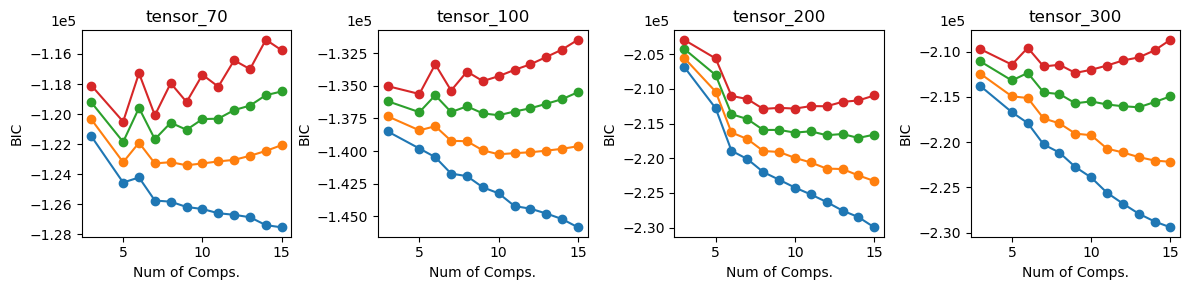

In [7]:
gamma_lists = [gamma_bics_70_cent, gamma_bics_100_cent, gamma_bics_200_cent, gamma_bics_300_cent]
x_values = [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
visualize_gamma_lists(gamma_lists, x_values)

In [8]:
for i in range(len(gamma_ranks_70_cent)):
    print("For gamma {}, the best rank is {} for tensor_70_cent, {} for tensor_100_cent, {} for tensor_200_cent and {} for tensor_300_cent.".format(i+1, gamma_ranks_70_cent[i][gamma_bics_70_cent[i].index(min(gamma_bics_70_cent[i]))],gamma_ranks_100_cent[i][gamma_bics_100_cent[i].index(min(gamma_bics_100_cent[i]))],gamma_ranks_200_cent[i][gamma_bics_200_cent[i].index(min(gamma_bics_200_cent[i]))],gamma_ranks_300_cent[i][gamma_bics_300_cent[i].index(min(gamma_bics_300_cent[i]))]))

For gamma 1, the best rank is [4 4 7] for tensor_70_cent, [5 4 6] for tensor_100_cent, [4 5 6] for tensor_200_cent and [4 6 5] for tensor_300_cent.
For gamma 2, the best rank is [2 3 4] for tensor_70_cent, [2 3 5] for tensor_100_cent, [4 5 6] for tensor_200_cent and [4 6 5] for tensor_300_cent.
For gamma 3, the best rank is [1 2 2] for tensor_70_cent, [2 3 5] for tensor_100_cent, [3 5 6] for tensor_200_cent and [3 5 5] for tensor_300_cent.
For gamma 4, the best rank is [1 2 2] for tensor_70_cent, [1 2 2] for tensor_100_cent, [2 3 3] for tensor_200_cent and [2 3 4] for tensor_300_cent.


In [9]:
# Prepare BIC ranks per type
bic_ranks = {
    # "Normal": {
    #     "tensor_70": list(gamma_ranks_70_nn[0][gamma_bics_70_nn[0].index(min(gamma_bics_70_nn[0]))]),
    #     "tensor_100": list(gamma_ranks_100_nn[0][gamma_bics_100_nn[0].index(min(gamma_bics_100_nn[0]))]),
    #     "tensor_200": list(gamma_ranks_200_nn[0][gamma_bics_200_nn[0].index(min(gamma_bics_200_nn[0]))]),
    #     "tensor_300": list(gamma_ranks_300_nn[0][gamma_bics_300_nn[0].index(min(gamma_bics_300_nn[0]))]),
    # },
    # "log": {
    #     "tensor_70": list(gamma_ranks_70_nn_log[0][gamma_bics_70_nn_log[0].index(min(gamma_bics_70_nn_log[0]))]),
    #     "tensor_100": list(gamma_ranks_100_nn_log[0][gamma_bics_100_nn_log[0].index(min(gamma_bics_100_nn_log[0]))]),
    #     "tensor_200": list(gamma_ranks_200_nn_log[0][gamma_bics_200_nn_log[0].index(min(gamma_bics_200_nn_log[0]))]),
    #     "tensor_300": list(gamma_ranks_300_nn_log[0][gamma_bics_300_nn_log[0].index(min(gamma_bics_300_nn_log[0]))]),
    # },
    "cent": {
        "tensor_70": list(gamma_ranks_70_cent[0][gamma_bics_70_cent[0].index(min(gamma_bics_70_cent[0]))]),
        "tensor_100": list(gamma_ranks_100_cent[0][gamma_bics_100_cent[0].index(min(gamma_bics_100_cent[0]))]),
        "tensor_200": list(gamma_ranks_200_cent[0][gamma_bics_200_cent[0].index(min(gamma_bics_200_cent[0]))]),
        "tensor_300": list(gamma_ranks_300_cent[0][gamma_bics_300_cent[0].index(min(gamma_bics_300_cent[0]))]),
    }
}


# SVD 

## Relative error

In [10]:
def estimate_tucker_ranks(tensor, threshold):
    ranks = []
    for mode in range(tensor.ndim):
        matricized = tl.unfold(tensor,mode)
        
        U, S, Vt = svd(matricized, full_matrices=False)

        error_r = 1 - np.sqrt(np.cumsum(S**2) / np.sum(S**2))
        rank = np.where(error_r < threshold)[0][0] + 1
        ranks.append(rank)
    
    return tuple(ranks)

In [11]:
estimated_ranks_70_cent = estimate_tucker_ranks(tensor_70_cent, 0.1)
print("Estimated Tucker Ranks for tensor_70_cent:", estimated_ranks_70_cent)
estimated_ranks_100_cent = estimate_tucker_ranks(tensor_100_cent, 0.1)
print("Estimated Tucker Ranks for tensor_100_cent:", estimated_ranks_100_cent)
estimated_ranks_200_cent = estimate_tucker_ranks(tensor_200_cent, 0.1)
print("Estimated Tucker Ranks for tensor_200_cent:", estimated_ranks_200_cent)
estimated_ranks_300_cent = estimate_tucker_ranks(tensor_300_cent, 0.1)
print("Estimated Tucker Ranks for tensor_300_cent:", estimated_ranks_300_cent)

Estimated Tucker Ranks for tensor_70_cent: (5, 2, 5)
Estimated Tucker Ranks for tensor_100_cent: (5, 3, 5)
Estimated Tucker Ranks for tensor_200_cent: (3, 3, 3)
Estimated Tucker Ranks for tensor_300_cent: (4, 4, 3)


In [12]:
svd_rel_error = {
    # "Normal": {
    #     "tensor_70": estimated_ranks_70,
    #     "tensor_100": estimated_ranks_100,
    #     "tensor_200": estimated_ranks_200,
    #     "tensor_300": estimated_ranks_300,
    # },
    # "log": {
    #     "tensor_70": estimated_ranks_70_log,
    #     "tensor_100": estimated_ranks_100_log,
    #     "tensor_200": estimated_ranks_200_log,
    #     "tensor_300": estimated_ranks_300_log,
    # },
    "cent": {
        "tensor_70": estimated_ranks_70_cent,
        "tensor_100": estimated_ranks_100_cent,
        "tensor_200": estimated_ranks_200_cent,
        "tensor_300": estimated_ranks_300_cent,
    }
}

## Variance vs. reconstruction error

In [13]:
# Set global font sizes
plt.rcParams.update({
    "font.size": 22,        # Default text size
    "axes.titlesize": 22,   # Title size
    "axes.labelsize": 22,   # X and Y label size
    "xtick.labelsize": 20,  # X tick labels
    "ytick.labelsize": 20,  # Y tick labels
    "legend.fontsize": 19,  # Legend text size
    "figure.titlesize": 23,  # Suptitle font size
    "lines.linewidth": 3  # Increase line thickness
})

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import svd
from kneed import KneeLocator
import tensorly as tl

def error(original, res):
    """Compute normalized reconstruction error."""
    assert original.shape == res.shape
    return np.sum((original - res)**2) / np.sum(original**2)

def compute_svd_ranks(tensor, tensor_name, threshold=0.75, error_threshold=0.05, method="variance", plot_s=False, type=None):
    """
    Computes the optimal rank for each mode using SVD, selecting ranks based on 
    either variance retention or reconstruction error.
    """
    ranks_selected = []
    thres_rank = []

    fig, axes = plt.subplots(1, 3, figsize=(18, 3))
    fig.subplots_adjust(wspace=0.5, hspace=0.4, bottom=0.1)
    fig.suptitle(f"{'Cumulative Variance' if method == 'variance' else 'Reconstruction Error'} for tensor_{tensor_name}_{type}", y=1.12)

    if plot_s:
        fig2, axes2 = plt.subplots(1, 3, figsize=(18, 3))
        fig2.subplots_adjust(wspace=0.5, hspace=0.4, bottom=0.1)
        fig2.suptitle(f"Singular values for tensor_{tensor_name}_{type}", y=1.12)

    for mode in range(tl.ndim(tensor)):
        matricized = tl.unfold(tensor, mode)
        U, S, Vt = svd(matricized, full_matrices=False)
        
        if plot_s:
            axes2[mode].bar(np.arange(1, len(S) + 1), S)
            axes2[mode].set_xlabel('Singular value')
            axes2[mode].set_ylabel('Magnitude')
            axes2[mode].set_title(f'Mode {mode}')
        
        if method == "variance":
            cumulative_variance = np.cumsum(S**2) / np.sum(S**2)
            selected_rank = np.where(cumulative_variance > threshold)[0][0] + 1
            thres_rank.append(selected_rank)

            elbow_locator = KneeLocator(np.arange(1, len(S) + 1), cumulative_variance, curve="concave", direction="increasing")
            selected_rank_elbow = elbow_locator.knee if elbow_locator.knee else selected_rank

            ax = axes[mode]
            ax.plot(np.arange(1, len(S) + 1), cumulative_variance, marker='o', linestyle='-', label='Cumulative Variance', linewidth=3)
            ax.axvline(x=selected_rank_elbow, color='r', linestyle='--', label='Elbow', linewidth=3)
            ax.axvline(x=selected_rank, color='k', linestyle='--', label=f'Threshold ({threshold})', linewidth=3)
            ax.set_ylabel("Cumulative Variance")
        
        elif method == "reconstruction_error":
            ranks = np.arange(1, len(S) + 1)
            errors = np.zeros_like(ranks, dtype=float)

            for i, r in enumerate(ranks):
                reconstructed = (U[:, :r] @ np.diag(S[:r]) @ Vt[:r, :])
                errors[i] = error(matricized, reconstructed)

            selected_rank = np.where(errors < error_threshold)[0][0] + 1
            thres_rank.append(selected_rank)
            elbow_locator = KneeLocator(ranks, errors, curve="convex", direction="decreasing")
            selected_rank_elbow = elbow_locator.knee or ranks[-1]

            ax = axes[mode]
            ax.plot(ranks, errors, color='g', marker='o', linestyle='-', label="Reconstruction Error", linewidth=3)
            ax.axvline(selected_rank_elbow, color='r', linestyle='--', label="Elbow", linewidth=3)
            ax.axvline(x=selected_rank, color='k', linestyle='--', label=f'Threshold ({error_threshold})', linewidth=3)
            ax.set_ylabel("Error")

        ranks_selected.append(selected_rank_elbow)
        ax.set_xlabel("Number of Components")
        ax.set_title(f"Mode {mode}")
        ax.grid()

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.35), ncol=3)
    fig.savefig(f"{'Cumulative Variance' if method == 'variance' else 'Reconstruction Error'} for tensor_{tensor_name}_{type}.png", format="png", bbox_inches="tight")
    fig.savefig(f"{'Cumulative Variance' if method == 'variance' else 'Reconstruction Error'} for tensor_{tensor_name}_{type}.pdf", format="pdf", bbox_inches="tight")

    if plot_s:
        fig2.savefig(f"Singular values for tensor_{tensor_name}_{type}.png", format="png", bbox_inches="tight")
        fig2.savefig(f"Singular Values for tensor_{tensor_name}_{type}.pdf", format="pdf", bbox_inches="tight")
    
    plt.show()
    return ranks_selected, thres_rank

Rank selection for tensor_70


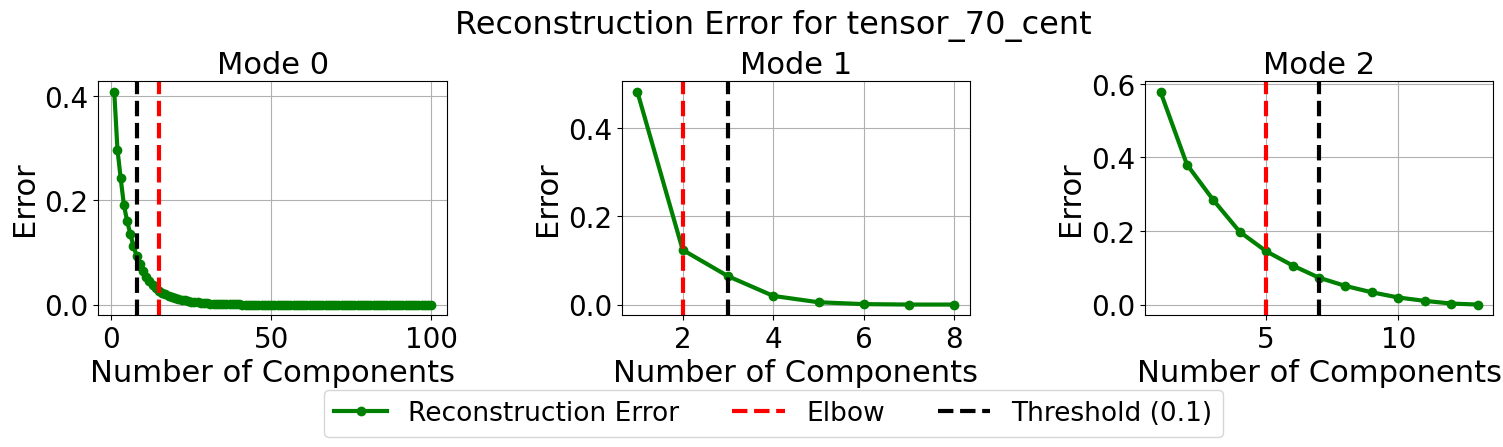

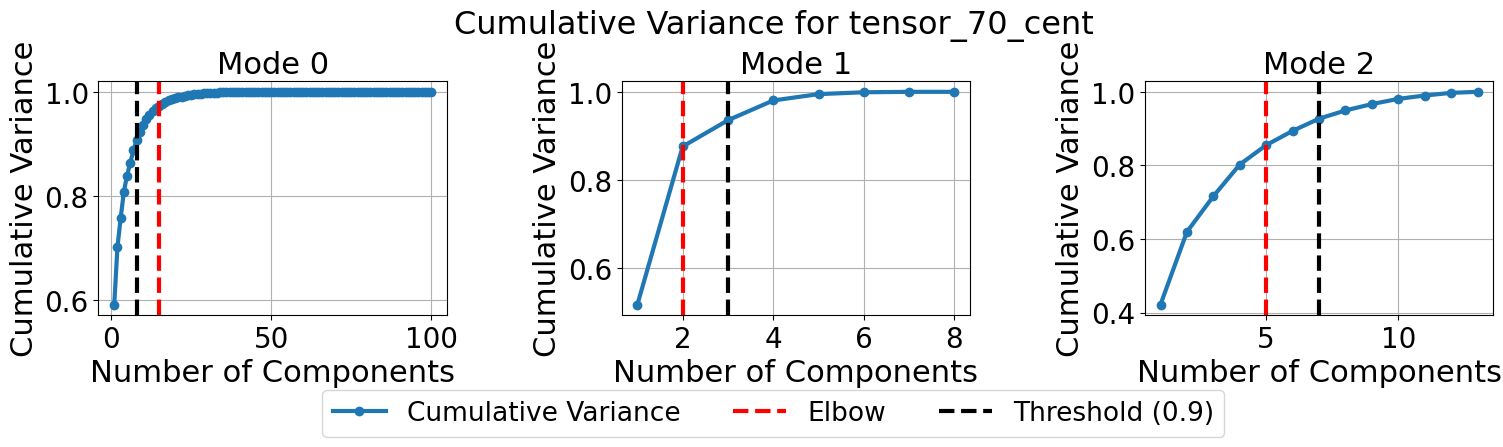

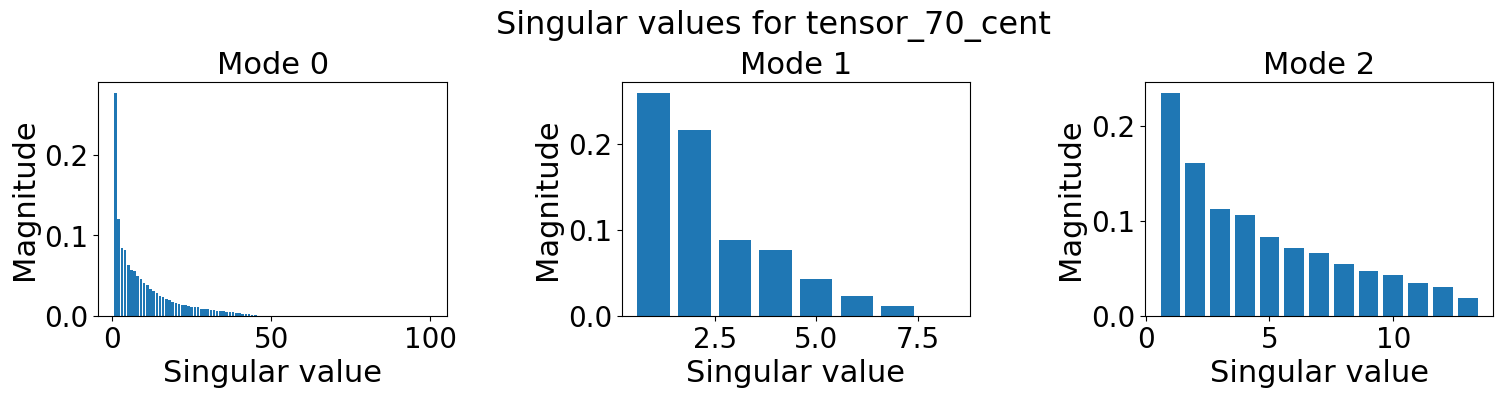

Rank selection for tensor_100


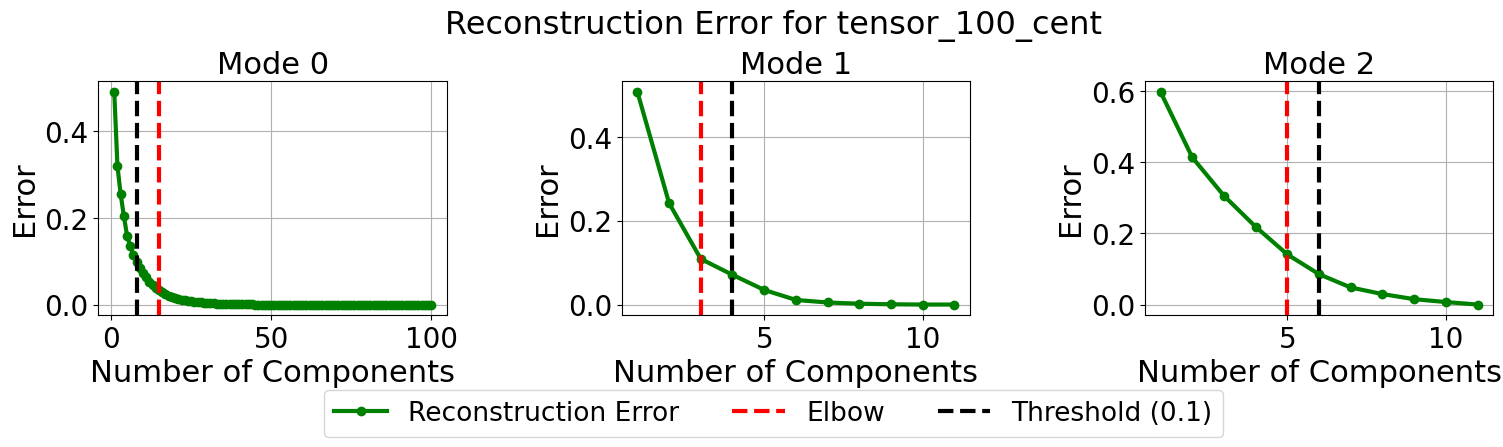

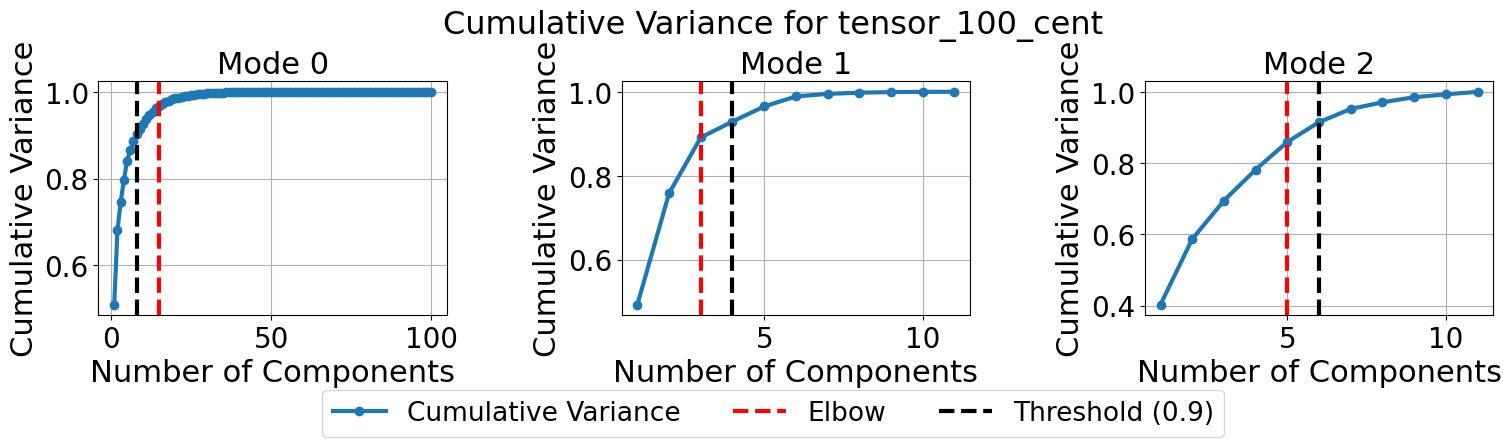

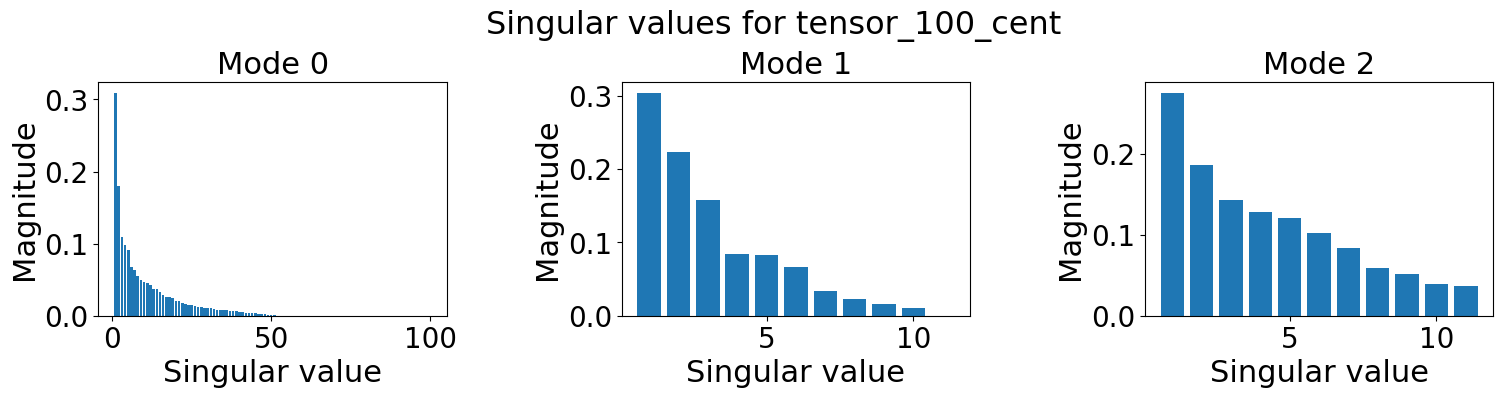

Rank selection for tensor_200


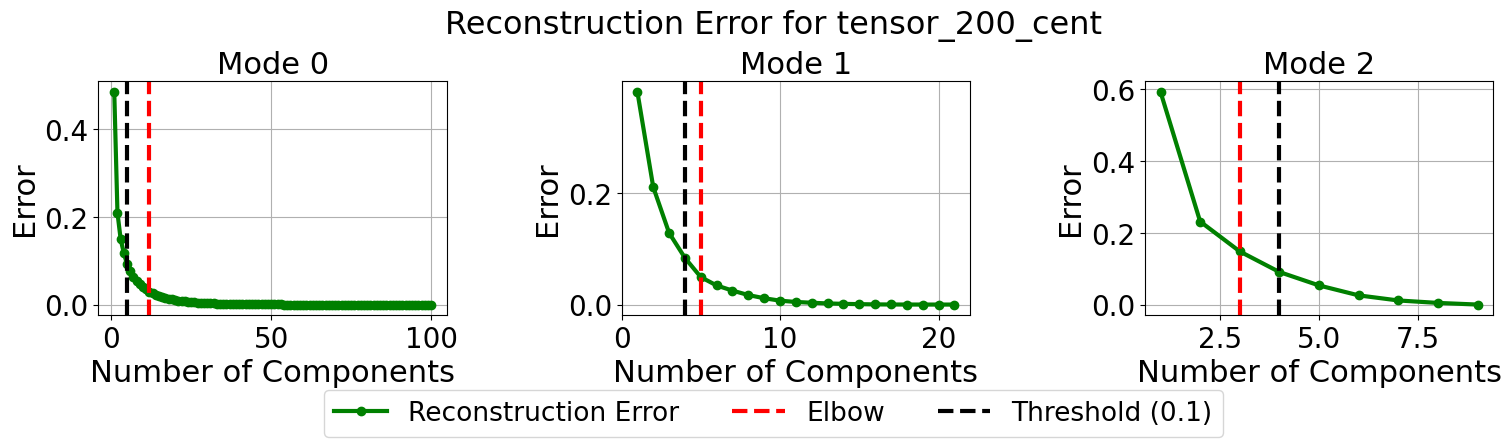

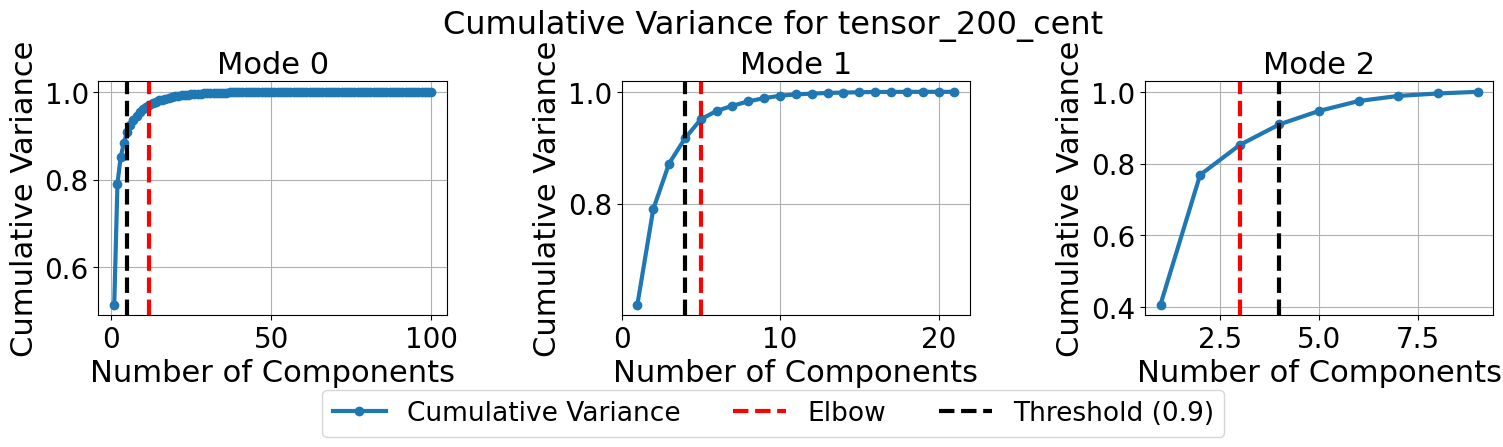

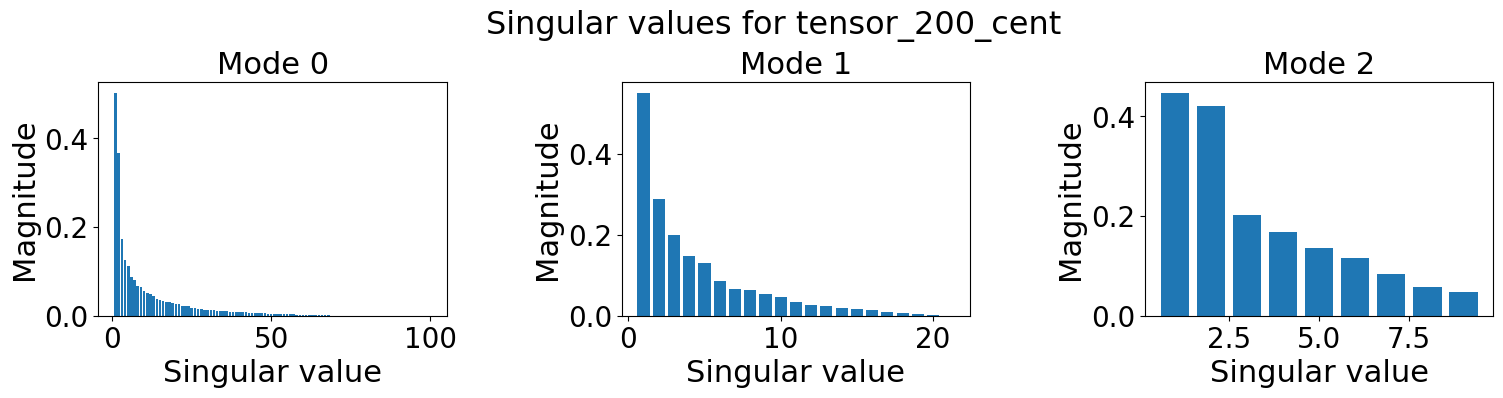

Rank selection for tensor_300


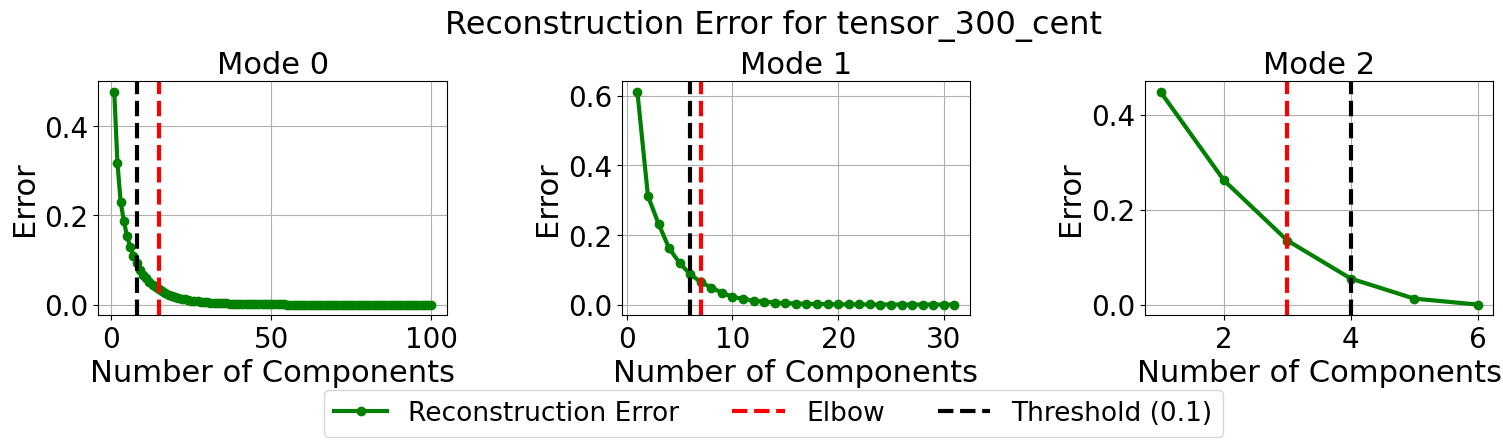

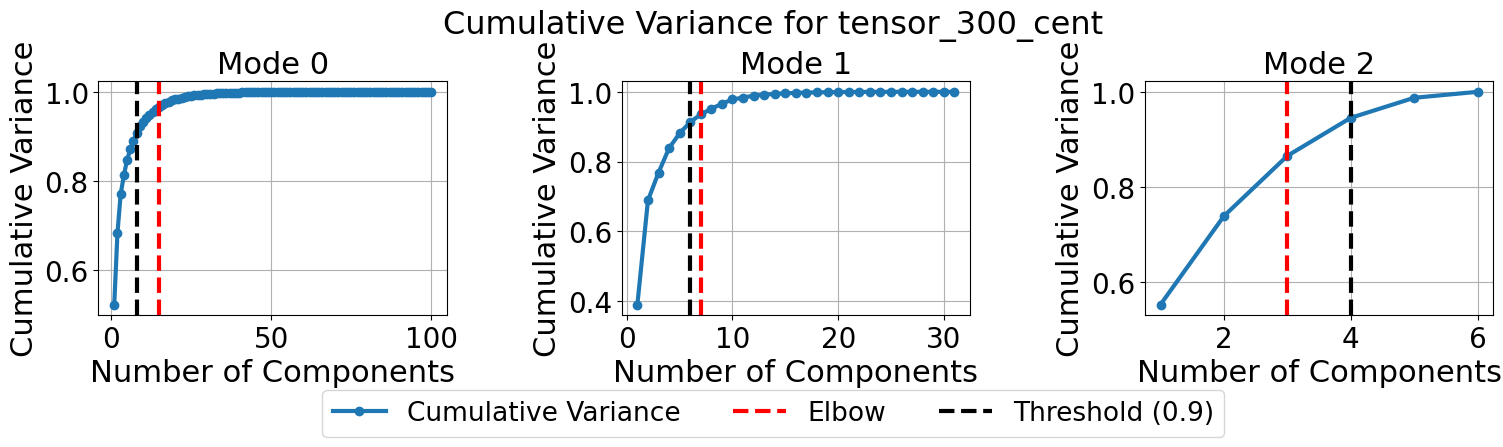

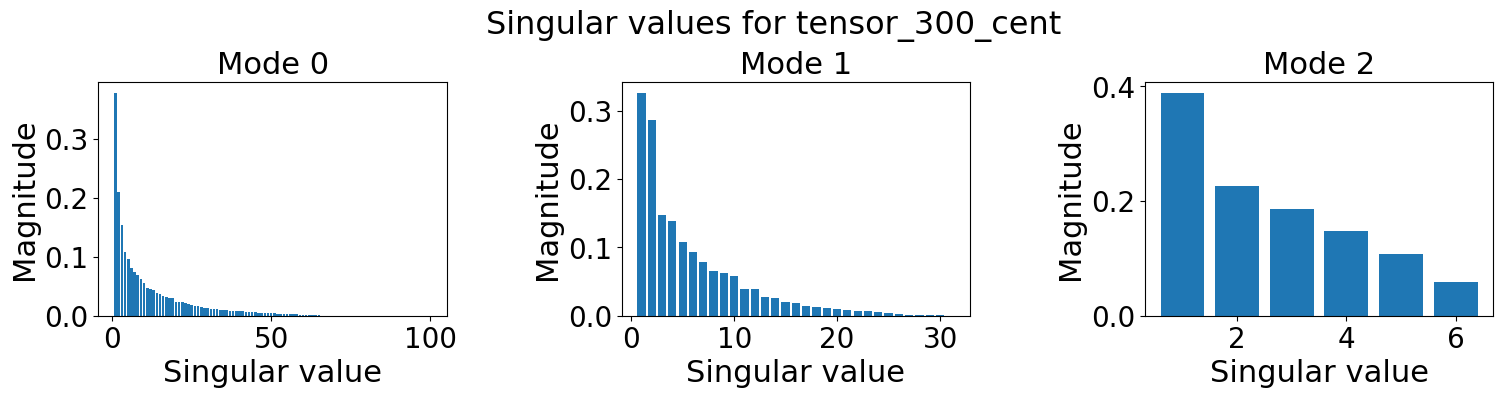


 For cent:

  FINAL RANKS (Explained Variance - threshold=0.9):
        Final Ranks for tensor_70: elbow --> [15, 2, 5], threshold --> [8, 3, 7]
        Final Ranks for tensor_100: elbow --> [15, 3, 5], threshold --> [8, 4, 6]
        Final Ranks for tensor_200: elbow --> [12, 5, 3], threshold --> [5, 4, 4]
        Final Ranks for tensor_300: elbow --> [15, 7, 3], threshold --> [8, 6, 4]

  FINAL RANKS (Reconstruction Error - threshold=0.1):
        Final Ranks for tensor_70: elbow --> [15, 2, 5], threshold --> [8, 3, 7]
        Final Ranks for tensor_100: elbow --> [15, 3, 5], threshold --> [8, 4, 6]
        Final Ranks for tensor_200: elbow --> [12, 5, 3], threshold --> [5, 4, 4]
        Final Ranks for tensor_300: elbow --> [15, 7, 3], threshold --> [8, 6, 4]


In [16]:
types=['cent']
final_ranks_variance = [[] for _ in types]
final_ranks_thresh = [[] for _ in types]
final_ranks_reconstruction = [[] for _ in types]
final_ranks_reconstruction_thresh = [[] for _ in types]
tensors=tensors_cent
tensor_names=tensor_names_cent

threshold = 0.9  # Variance retention threshold
error_threshold = 0.1  # Acceptable reconstruction error threshold
for t,type in enumerate(types):
    # if type=='':
    #     type_text='Normal'
    # else:
    #     type_text=type
    # print(f'\n For {type_text}:')
    # Run for all our tensors using Variance Method

    for i, tensor in enumerate(tensors):
        tensor_name = tensor_names[i]  # To label the tensor (e.g., time 70, 100, 200, 300)
        print(f'Rank selection for tensor_{tensor_name}')

        # Compute ranks using Reconstruction Error-based selection
        selected_ranks_reconstruction, error_thres_ranks = compute_svd_ranks(tensor, tensor_name, threshold=threshold, error_threshold=error_threshold, method="reconstruction_error",type=type)
        final_ranks_reconstruction[t].append(selected_ranks_reconstruction)
        final_ranks_reconstruction_thresh[t].append(error_thres_ranks)

        # Compute ranks using Variance-based selection
        selected_ranks_variance, thres_ranks = compute_svd_ranks(tensor, tensor_name, threshold=threshold, error_threshold=error_threshold, method="variance", plot_s=True,type=type)
        final_ranks_variance[t].append(selected_ranks_variance)
        final_ranks_thresh[t].append(thres_ranks)

        
# Print final ranks for Variance method
for t,type in enumerate(types):
    if type=='':
        type_text='Normal'
    else:
        type_text=type
    print(f'\n For {type_text}:')
    print(f'\n  FINAL RANKS (Explained Variance - threshold={threshold}):')
    for i, tensor in enumerate(tensors):
        print(f"        Final Ranks for tensor_{tensor_names[i]}: elbow --> {final_ranks_variance[t][i]}, threshold --> {final_ranks_thresh[t][i]}")

    # Print final ranks for Reconstruction Error method
    print(f'\n  FINAL RANKS (Reconstruction Error - threshold={error_threshold}):')
    for i, tensor in enumerate(tensors):
        print(f"        Final Ranks for tensor_{tensor_names[i]}: elbow --> {final_ranks_reconstruction[t][i]}, threshold --> {final_ranks_reconstruction_thresh[t][i]}")


# Components comparison
We want to compare the above methods globally:

1. Factor Matrices → How similar are the components across all methods?
2. Core Tensors → Do the decompositions represent the same latent structure?
3. Reconstruction Errors → Which method best reconstructs the data?

In [17]:
# Example DIFIT ranks (replace with your real ones)
ranks_DIFIT = {
    # "Normal": {
    #     "tensor_70": [3, 1, 3],
    #     "tensor_100": [2, 1, 2],
    #     "tensor_200": [3, 2, 3],
    #     "tensor_300": [2, 1, 2],
    # },
    # "log": {
    #     "tensor_70": [2, 1, 2],
    #     "tensor_100": [1, 1, 1],
    #     "tensor_200": [2, 1, 2],
    #     "tensor_300": [1, 1, 1],
    # },
    "cent": {
        "tensor_70": [1, 2, 1], #2,2,3
        "tensor_100": [2, 2, 3], #5,3,6
        "tensor_200": [2, 2, 2],
        "tensor_300": [2, 3, 3], #2,4,4
    }
}


In [18]:


# Define type and tensor labels
types = ['cent']
type_names = ['cent']
tensor_names = ["70", "100", "200", "300"]
tensor_labels = [f"tensor_{name}" for name in tensor_names]

# Initialize dictionary
rank_dictionaries = {}

for t_idx, type_name in enumerate(type_names):
    rank_dictionaries[type_name] = {
        "DIFIT": {},
        "BIC": {},
        "SVD Relative Error": {},
        "SVD Variance (Elbow)": {},
        "SVD Variance (Threshold)": {},
        "SVD Reconstruction Error (Elbow)": {},
        "SVD Reconstruction Error (Threshold)": {}
    }

    for i, tensor_label in enumerate(tensor_labels):
        # DIFIT and BIC (same across types)
        rank_dictionaries[type_name]["DIFIT"][tensor_label] = ranks_DIFIT[type_name][tensor_label]
        rank_dictionaries[type_name]["BIC"][tensor_label] = bic_ranks[type_name][tensor_label]
        rank_dictionaries[type_name]["SVD Relative Error"][tensor_label] = svd_rel_error[type_name][tensor_label]

        # SVD-based methods (change with type)
        rank_dictionaries[type_name]["SVD Variance (Elbow)"][tensor_label] = final_ranks_variance[t_idx][i]
        rank_dictionaries[type_name]["SVD Variance (Threshold)"][tensor_label] = final_ranks_thresh[t_idx][i]
        rank_dictionaries[type_name]["SVD Reconstruction Error (Elbow)"][tensor_label] = final_ranks_reconstruction[t_idx][i]
        rank_dictionaries[type_name]["SVD Reconstruction Error (Threshold)"][tensor_label] = final_ranks_reconstruction_thresh[t_idx][i]

for type_name in type_names:
    print(f"\n===== {type_name.upper()} =====")
    for method in rank_dictionaries[type_name].keys():
        print(f"\n  {method}:")
        for tensor_label in tensor_labels:
            ranks = rank_dictionaries[type_name][method][tensor_label]
            print(f"    {tensor_label}: {ranks}", end="")
        print('\n')



===== CENT =====

  DIFIT:
    tensor_70: [1, 2, 1]    tensor_100: [2, 2, 3]    tensor_200: [2, 2, 2]    tensor_300: [2, 3, 3]


  BIC:
    tensor_70: [4, 4, 7]    tensor_100: [5, 4, 6]    tensor_200: [4, 5, 6]    tensor_300: [4, 6, 5]


  SVD Relative Error:
    tensor_70: (5, 2, 5)    tensor_100: (5, 3, 5)    tensor_200: (3, 3, 3)    tensor_300: (4, 4, 3)


  SVD Variance (Elbow):
    tensor_70: [15, 2, 5]    tensor_100: [15, 3, 5]    tensor_200: [12, 5, 3]    tensor_300: [15, 7, 3]


  SVD Variance (Threshold):
    tensor_70: [8, 3, 7]    tensor_100: [8, 4, 6]    tensor_200: [5, 4, 4]    tensor_300: [8, 6, 4]


  SVD Reconstruction Error (Elbow):
    tensor_70: [15, 2, 5]    tensor_100: [15, 3, 5]    tensor_200: [12, 5, 3]    tensor_300: [15, 7, 3]


  SVD Reconstruction Error (Threshold):
    tensor_70: [8, 3, 7]    tensor_100: [8, 4, 6]    tensor_200: [5, 4, 4]    tensor_300: [8, 6, 4]



C:\Users\viola\AppData\Local\Temp\ipykernel_9640\2471371882.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab10", num_methods).colors


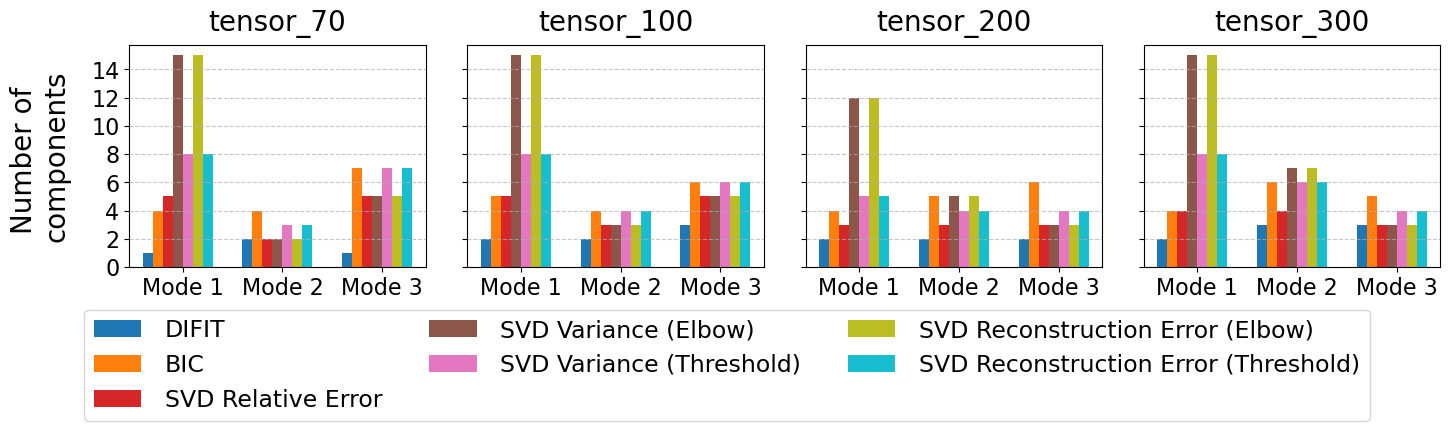

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Define modes and tensor/type names
modes = [1, 2, 3]
x_positions = np.arange(len(modes))
type_names = ["cent"]
tensor_names = ["tensor_70", "tensor_100", "tensor_200", "tensor_300"]
methods = list(rank_dictionaries["cent"].keys())
num_methods = len(methods)

# Bar settings
bar_width = 0.1
colors = plt.cm.get_cmap("tab10", num_methods).colors

# Create subplot grid
fig, axes = plt.subplots(len(type_names), len(tensor_names), figsize=(15, 4), sharey=True)

for row_idx, type_name in enumerate(type_names):
    for col_idx, tensor in enumerate(tensor_names):
        ax = axes[row_idx][col_idx] if len(type_names) > 1 else axes[col_idx]

        # Plot bars per method
        for m_idx, method in enumerate(methods):
            ranks = rank_dictionaries[type_name][method][tensor]
            offset = (m_idx - num_methods / 2) * bar_width
            ax.bar(x_positions + offset, ranks, width=bar_width, color=colors[m_idx], label=method if row_idx == 0 and col_idx == 0 else "")

        ax.set_xticks(x_positions)
        ax.set_xticklabels([f"Mode {m}" for m in modes])
        ax.tick_params(axis='x', labelsize=16)  # Smaller x-axis labels
        ax.tick_params(axis='y', labelsize=16)  # Y-axis tick size (can be adjusted)

        # Add more y-axis ticks
        ax.yaxis.set_major_locator(plt.MaxNLocator(10))  # Up to 10 ticks on y-axis

        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Only show column titles on top row
        if row_idx == 0:
            ax.set_title(f"{tensor}", fontsize=20, pad=10)

        # Only show row labels on the leftmost column
        if col_idx == 0:
            ax.set_ylabel(f"Number of \ncomponents", fontsize=20, labelpad=15)

# Global legend
fig.legend(
    methods, loc="lower center", ncol=3, fontsize=17,
    bbox_to_anchor=(0.5, -0.2), columnspacing=2.0, handletextpad=1.0
)

# Tighter layout and reduced space above plots
plt.tight_layout(rect=[0, 0.05, 1, 0.94])
# plt.suptitle("Nº Components", fontsize=26, y=0.975)

# Save plots
plt.savefig("rank_selection.pdf", format="pdf", bbox_inches="tight")
plt.savefig("rank_selection.png", format="png", bbox_inches="tight")

# Show
plt.show()


In [47]:

import pickle

# Define the path for saving
save_path = "rank_selection_results.pkl"

# Save the dictionary using Pickle (binary format)
with open(save_path, "wb") as pickle_file:
    pickle.dump(rank_dictionaries, pickle_file)

print(f"Rank selection results saved successfully to {save_path} (Pickle format)")



Rank selection results saved successfully to rank_selection_results.pkl (Pickle format)
